In [292]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [293]:
#Read Training File
df_train=pd.read_csv("train.csv")
df_train["source"]="Train"

#Read Test File
df_test=pd.read_csv("test.csv")
df_test["source"]="Test"

#Concat Dataset and split to X and Y
df=pd.concat([df_test,df_train], axis=0)
X=df.drop("SalePrice",axis=1)
y=df["SalePrice"]

#Save source as series and drop from DF
source=df["source"]
df.drop("source", axis=1, inplace=True)

# Feature Engineering: Cleaning

In [294]:
# Defining categorical and numerical variables
num_cols=X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols=X.columns.values[X.dtypes=="object"]

### One-Hot-Encoding

In [295]:
for each in cat_cols:
    dummies=pd.get_dummies(X[each])
    #dummies=dummies[1:]
    X=pd.concat([X,dummies],axis=1)
    X.drop(each,axis=1,inplace=True)

### Missing Values

In [296]:
for each in X.columns.values:
    #X[each]=X[each].fillna(np.median(X[each]))
    X[each]=X[each].fillna(0)

In [297]:
X.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,ConLw,New,Oth,WD,Grvl,Pave,AllPub,NoSeWa,Test,Train
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.272011,49.565262,0.429599,0.061322,560.579993,23.098321,...,0.002741,0.081877,0.002398,0.865022,0.004111,0.995889,0.998972,0.000343,0.499829,0.500171
std,392.362079,428.701456,25.188169,0.822693,455.606014,169.179104,0.524676,0.245608,439.590889,64.244246,...,0.052289,0.274225,0.048920,0.341758,0.063996,0.063996,0.032048,0.018509,0.500086,0.500086
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalization

In [298]:
# Normalize
for each in X.columns.values:
    X[each] = (X[each]-X[each].min())/(X[each].max()-X[each].min())
    
#standardize or normalize??
#schneller mit NP

In [299]:
X.fillna(0, inplace=True)
#Naja...

## Split Training and Test

In [300]:
#Split Set (using source)
def sync_datasets(X,y):
    X_train = X[source=="Train"]
    y_train = y[source=="Train"]
    X_test= X[source=="Test"]
    return X_train, y_train, X_test

X_train, y_train, X_test = sync_datasets(X,y)

#X_train, X_test, y_train, y_test=train_test_split(X,y)

# Feature Selection

In [301]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor()

### Drop non-corelating variables

In [302]:
correlations=pd.concat([X,y], axis=1).corr()["SalePrice"]
keep_cols=(abs(correlations)>0.1) & (correlations<1)
keep_cols=keep_cols[0:291]
#Das muss noch anders gelöst werden
X=X[X.columns.values[keep_cols]]

### Recursive Feature Selection
This step should help us to get on idea on the right number of parameters.

In [303]:
from sklearn.feature_selection import RFECV

In [305]:
rfecv = RFECV(estimator=Boosting,scoring="explained_variance", step=5)
rfecv.fit(X=X_train,y=y_train)

RFECV(cv=None,
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
   n_jobs=1, scoring='explained_variance', step=5, verbose=0)

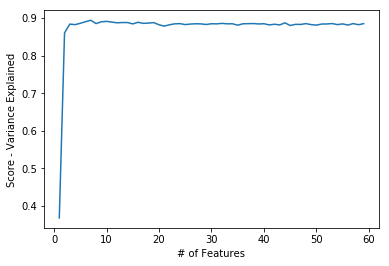

Optimal number of features 31


In [306]:
# Plot relationship #of features and performance
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel("# of Features")
plt.ylabel("Score - Variance Explained")
plt.show()
print("Optimal number of features {}".format(rfecv.n_features_))

In [307]:
#Select important columns
selected_cols=X_train.columns.values[rfecv.support_]
X_train=X_train[selected_cols]
X_test=X_test[selected_cols]

# Feature Engineering: Creative

## Dependent Variable

In [308]:
#plt.hist(y_train)

In [309]:
#plt.hist(np.log(y_train))

In [310]:
#y_train=np.log(y_train)

## Models: Train

In [311]:
#Random Forest Regressor
RandomForest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [312]:
from sklearn.linear_model import LinearRegression
Regression=LinearRegression()
Regression.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [313]:
from sklearn.svm import SVR
SVR=SVR()
SVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [314]:
from sklearn.ensemble import AdaBoostRegressor
Ada=AdaBoostRegressor()
Ada.fit(X=X_train,y=y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [315]:
from sklearn.ensemble import GradientBoostingRegressor
Boosting=GradientBoostingRegressor()
Boosting.fit(X=X_train,y=y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [316]:
model = [Regression, RandomForest, SVR, Ada,Boosting]

### Cross-Validation

In [317]:
from sklearn.model_selection import cross_val_score

In [323]:
for each in model:
    scores = cross_val_score(estimator=each,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
    print(str(each)+" "+str(scores.mean()))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 0.8028212738300027
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 0.8595373753125669
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 0.0003828615110116895
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None) 0.8219415265995405
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_d

### Prediction

In [319]:
prediction = Regression.predict(X_test)

In [320]:
prediction

array([111764.95616438, 163113.75616438, 178728.75616438, ...,
       178276.95616438, 118339.35616438, 230112.15616438])

In [321]:
# Reverting log
#prediction = np.exp(prediction)

In [322]:
# Writing Prediction to *.csv
submission = pd.read_csv("sample_submission.csv")
submission["SalePrice"]=prediction
submission.to_csv("submission.csv", index=False)

# Learnings

- Vor one-hot-enconding training und test dataset zusammen 
- What is a stratified fold?
- Variance explained for Regression?

# Results

1. Submit: Just one hot-encoding and Random Forest (Default): 0.15554
2. Submit: One hot-encoding and Random Forest (Default), RFECV: 0.15051 (2.857)
3. Submit: Like 2, +Log Target Variable, +Fill missing values with mean instead of 0:
4. Submit: Like 3, - Fill missing values with mean instead of 0: 0.15727
5. Submit: Normalized, median as input, pre-selected features: 0.16282
6. Submit: Model - Regression: 0.16721
7. Submit: Model - Boosting:0.19108 => overfitting

In [28]:
prediction

array([131518.04409477, 150408.90405007, 179933.05817397, ...,
       140911.31651799, 102626.78943427, 244981.90529338])

# Ideas
- Engineering
 - Remove colinearity
 - Impute Median
 - Normalize
- More Algos
- Hyperparameter